In [1]:
from typing import List, Dict

import empyrical as ep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from data_service import get_index_daily, get_sales_depart_billboard
from scr import HMA, calc_netbuy, get_exchange_set
from scr.plotting import plot_indicator, plot_distribution, plot_qunatile_signal
from scr.tushare_api import TuShare

my_ts = TuShare()

# 数据准备

In [3]:
# 数据获取
billboard_df: pd.DataFrame = get_sales_depart_billboard(
    '2013-01-01', '2022-02-02')

# 数据储存
billboard_df.to_csv('../data/billboard.csv', encoding='utf-8')

机构龙虎榜数据获取:   0%|          | 0/2207 [00:00<?, ?it/s]

2022-06-28 08:29:51,073 TuShare e:\WorkSpace\Quantitative-analysis\C-择时类\特征分布建模择时\scr\tushare_api.py:62 wrapper ERROR TuShare exec top_inst failed, args:(), kwargs:{'trade_date': '20160509'}, try again.
Traceback (most recent call last):
  File "d:\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 665, in urlopen
    httplib_response = self._make_request(
  File "d:\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "d:\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 416, in _make_request
    httplib_response = conn.getresponse()
  File "d:\anaconda3\lib\http\client.py", line 1347, in getresponse
    response.begin()
  File "d:\anaconda3\lib\http\client.py", line 331, in begin
    self.headers = self.msg = parse_headers(self.fp)
  File "d:\anaconda3\lib\http\client.py", line 216, in parse_headers
    line = fp.readline(_MAXLINE + 1)
  File "d:\anaconda3\li

2022-06-28 08:29:51,073 - TuShare - ERROR - TuShare exec top_inst failed, args:(), kwargs:{'trade_date': '20160509'}, try again.
Traceback (most recent call last):
  File "d:\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 665, in urlopen
    httplib_response = self._make_request(
  File "d:\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "d:\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 416, in _make_request
    httplib_response = conn.getresponse()
  File "d:\anaconda3\lib\http\client.py", line 1347, in getresponse
    response.begin()
  File "d:\anaconda3\lib\http\client.py", line 331, in begin
    self.headers = self.msg = parse_headers(self.fp)
  File "d:\anaconda3\lib\http\client.py", line 216, in parse_headers
    line = fp.readline(_MAXLINE + 1)
  File "d:\anaconda3\lib\socket.py", line 669, in readinto
    return self._sock.recv_into(b)
Con

In [2]:
# 读取本地文件
billboard_df: pd.DataFrame = pd.read_csv('../data/billboard.csv',
                                         encoding='utf-8',
                                         index_col=[0],
                                         parse_dates=['trade_date'])

In [3]:
# 获取沪深300数据
hs300: pd.DataFrame = get_index_daily(code='000300.SH',
                                      start_date='20130101',
                                      end_date='20220222')
hs300.set_index('trade_date', inplace=True)


In [4]:
# 查看数据结构
hs300.head()

,code,close,open,high,low,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2013-01-04,000300.SH,2524.409,2551.814,2558.529,2498.892,2522.952,1.457,0.0577,97988182.0,9.557925e+07
2013-01-07,000300.SH,2535.985,2518.047,2545.969,2511.603,2524.409,11.576,0.4586,75167993.0,7.316751e+07
2013-01-08,000300.SH,2525.330,2534.647,2540.513,2502.490,2535.985,-10.655,-0.4202,71837100.0,7.649806e+07
2013-01-09,000300.SH,2526.126,2518.104,2534.239,2504.299,2525.330,0.796,0.0315,70231170.0,7.423360e+07
2013-01-10,000300.SH,2530.569,2525.590,2553.352,2513.729,2526.126,4.443,0.1759,71085862.0,7.115905e+07


In [5]:
# 查看数据结构
billboard_df.head()

,trade_date,code,exalter,buy,buy_rate,sell,sell_rate,net_buy,side,reason
0,2013-01-04,000043.SZ,中国国际金融有限公司上海淮海中路证券营业部,16970815.06,1.19,16377628.0,1.24,-593187.06,0,连续三个交易日内，涨幅偏离值累计达20%的证券
264,2013-01-04,300262.SZ,光大证券股份有限公司深圳金田路证券营业部,17202495.10,2.03,5832845.6,5.98,-11369649.50,1,换手率达20%的证券
263,2013-01-04,300262.SZ,光大证券股份有限公司深圳金田路证券营业部,17202495.10,2.03,5832845.6,5.98,-11369649.50,0,换手率达20%的证券
262,2013-01-04,300262.SZ,中国银河证券股份有限公司厦门美湖路证券营业部,7913689.96,0.01,26770.0,2.75,-7886919.96,1,换手率达20%的证券
261,2013-01-04,300262.SZ,中信证券股份有限公司上海淮海中路证券营业部,4772872.77,1.53,4398000.0,1.66,-374872.77,0,换手率达20%的证券


## 席位分析

In [4]:
# 席位划分
exchange_set: Dict = get_exchange_set(billboard_df)


可以看到**机构席位**(图二):当相对净流入指标处于极值两端的时候,市场的未来期望收益率更高,即龙虎榜机构席位出现较大净流出或净流入后,后10日的沪深300指数对应为表现较好，而龙虎榜机构席位的净流入或净流出绝对值较低时，后10日的沪深300指数对应为表现较差。统计结果印证了机构龙虎榜影响下的有限注意力规律，即当机构席 位出现极端行为时很多的决策注意力被吸引而来，出现了较为明显的非线性交易规律， 整体的收益分布呈现出明显的V字型，即正收益来自于两端，负收益来自于中间。如果 择时因子与宽基未来收益显著正相关，且相关系数是 1，那么期望收益分布图则是一个 单调递增的形状。因此，期望收益分布图简单明了的表示择时因子与未来收益的非线性关系，而 IS_NetBuy_S 指标的期望收益分布图就是呈现出V型的非线性关系。

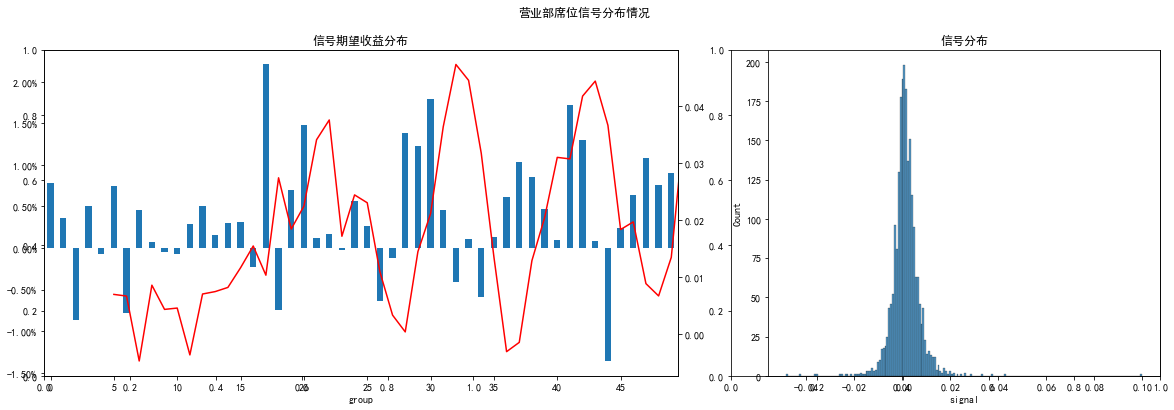

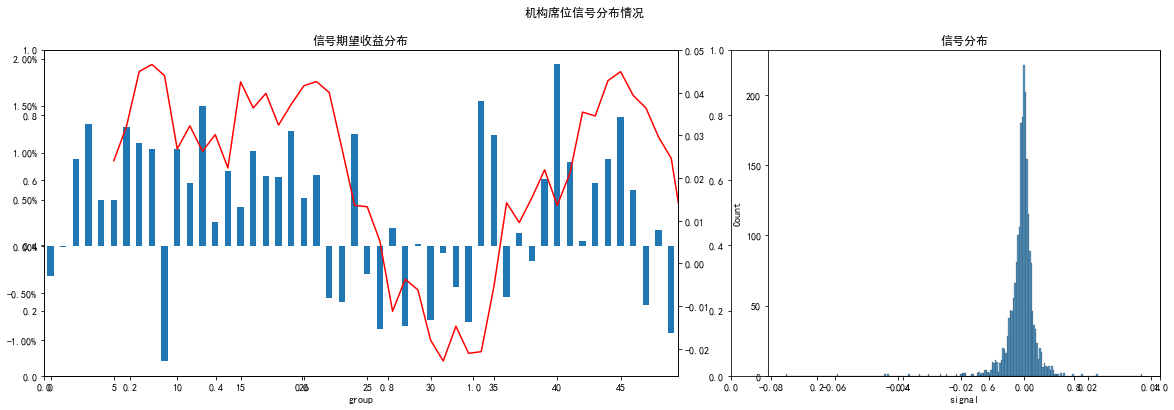

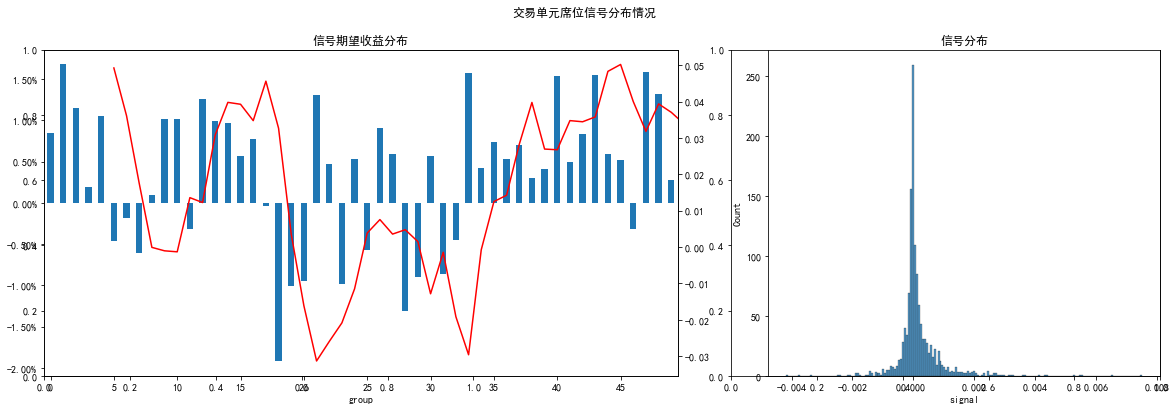

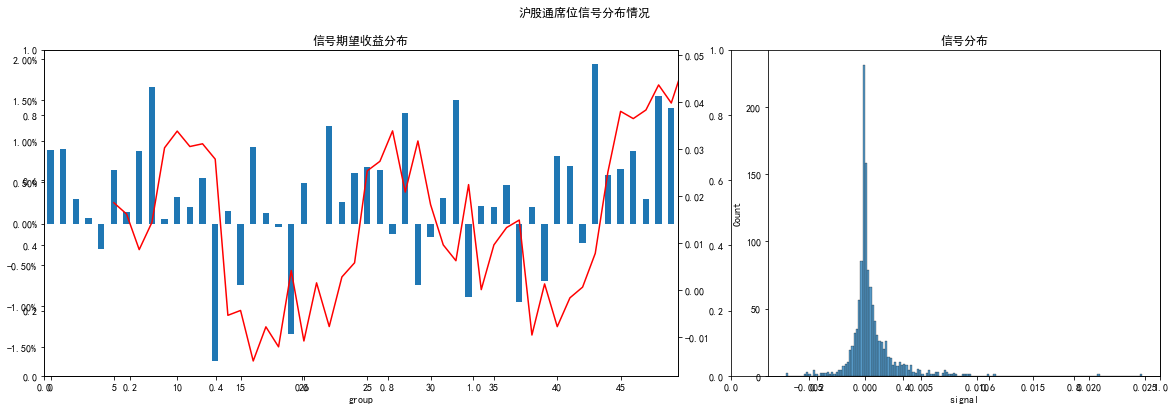

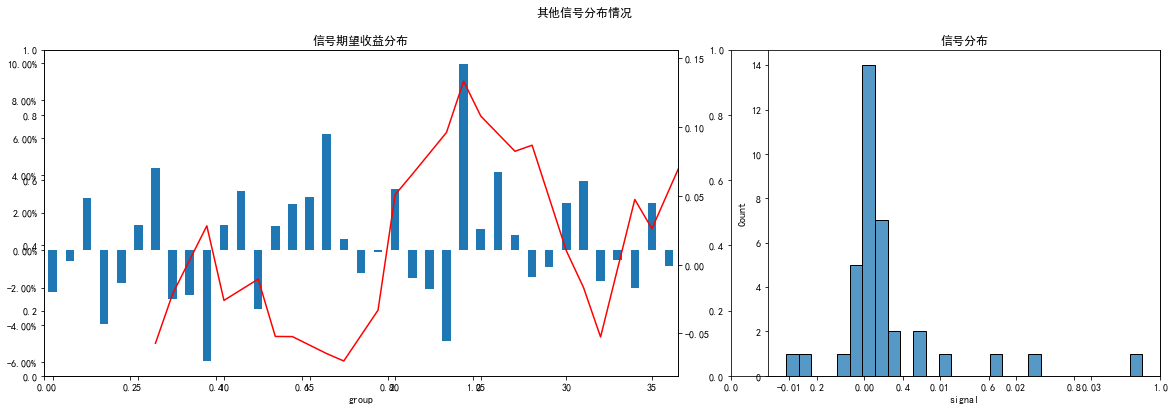

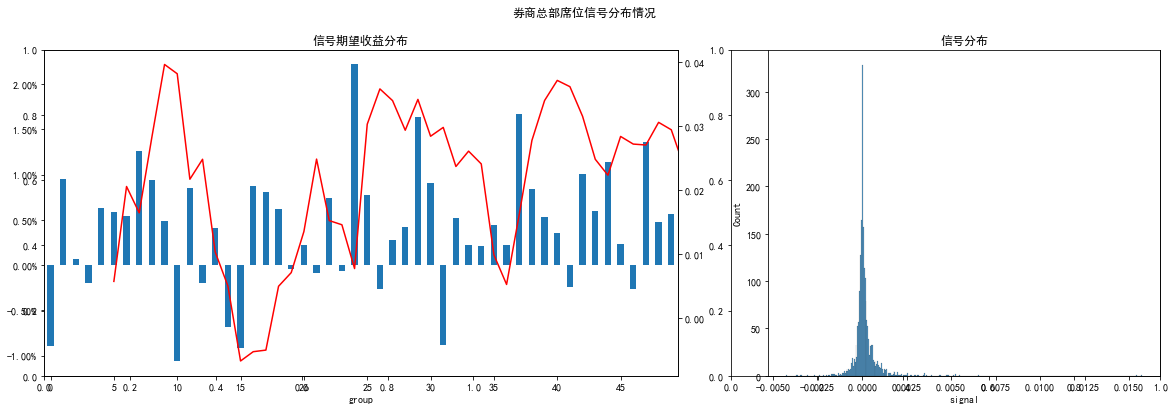

In [9]:
size: int = len(exchange_set)

for name, cond in exchange_set.items():

    is_netbuy_s: pd.Series = calc_netbuy(billboard_df[cond], hs300['amount'])
    plot_distribution(is_netbuy_s, hs300['close'], 10, f'{name}信号分布情况')


# VBT回测

In [69]:
import vectorbt as vbt

In [70]:
is_netbuy_s: pd.Series = calc_netbuy(billboard_df[exchange_set['机构席位']],
                                     hs300['amount'])
# 计算HMA信号
is_netbuy_s_s: pd.Series = HMA(is_netbuy_s, 30)
is_netbuy_s_l: pd.Series = HMA(is_netbuy_s, 100)

to_buy1: pd.Series = (is_netbuy_s_s > is_netbuy_s_l) & (is_netbuy_s_s > 0) & (
    is_netbuy_s_l > 0)
to_buy2: pd.Series = (is_netbuy_s_s < is_netbuy_s_l) & (is_netbuy_s_s < 0) & (
    is_netbuy_s_l < 0)

# 注:信号滞后 不然会有未来
entries: pd.Series = (to_buy1 | to_buy2).vbt.signals.fshift()
exits: pd.Series = (~entries)

direction = ['longonly']
fees = 0.001
pf = vbt.Portfolio.from_signals(
    close=hs300['close'].reindex(is_netbuy_s_s.index),
    price=hs300['open'].reindex(is_netbuy_s_s.index),
    entries=entries,
    exits=exits,
    direction=direction,
    fees=fees,
    log=True,
    freq='1D')


In [12]:
pf.orders.records_readable

,Order Id,Column,Timestamp,Size,Price,Fees,Side
0,0,0,2013-07-10,0.046184,2163.0980,0.099900,Buy
1,1,0,2013-07-18,0.046184,2272.9470,0.104973,Sell
2,2,0,2013-07-24,0.046492,2253.3760,0.104764,Buy
3,3,0,2013-08-08,0.046492,2277.2530,0.105874,Sell
4,4,0,2013-09-02,0.045545,2319.9570,0.105662,Buy
...,...,...,...,...,...,...,...
168,168,0,2021-11-02,0.058413,4886.1849,0.285414,Buy
169,169,0,2021-12-08,0.058413,4934.4056,0.288231,Sell
170,170,0,2022-01-07,0.059626,4824.3181,0.287655,Buy
171,171,0,2022-01-17,0.059626,4728.7595,0.281957,Sell


In [8]:
pf.stats()

Start                                2013-01-04 00:00:00
End                                  2022-01-28 00:00:00
Period                                2207 days 00:00:00
Start Value                                        100.0
End Value                                     272.767979
Total Return [%]                              172.767979
Benchmark Return [%]                            80.78576
Max Gross Exposure [%]                             100.0
Total Fees Paid                                31.461049
Max Drawdown [%]                               25.215775
Max Drawdown Duration                  328 days 00:00:00
Total Trades                                          87
Total Closed Trades                                   86
Total Open Trades                                      1
Open Trade PnL                                 -8.907539
Win Rate [%]                                    67.44186
Best Trade [%]                                 22.033293
Worst Trade [%]                

In [93]:
pf.stats(tags=['trades'])

Total Trades                                          87
Total Closed Trades                                   86
Total Open Trades                                      1
Open Trade PnL                                 -8.907539
Win Rate [%]                                    67.44186
Best Trade [%]                                 22.033293
Worst Trade [%]                               -20.474188
Avg Winning Trade [%]                           3.581759
Avg Losing Trade [%]                           -3.295777
Avg Winning Trade Duration    11 days 12:49:39.310344827
Avg Losing Trade Duration               10 days 18:00:00
Profit Factor                                   2.045786
Expectancy                                      2.112506
dtype: object

In [9]:
pf.plot(
    subplots=['orders', 'trade_pnl', 'cum_returns', 'drawdowns', 'underwater'])


FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'na…

# bt回测

In [5]:
from scr.bt_func import get_backtesting, netbuy_cross
from scr.timeseries import get_drawdown_table

In [6]:
is_netbuy_s: pd.Series = calc_netbuy(billboard_df[exchange_set['机构席位']],
                                     hs300['amount'])
# 计算HMA信号
is_netbuy_s_s: pd.Series = HMA(is_netbuy_s, 30)
is_netbuy_s_l: pd.Series = HMA(is_netbuy_s, 100)

is_netbuy_s_s.name = 'fast'
is_netbuy_s_l.name = 'slow'

In [7]:
bt_data = hs300.copy()
bt_data = pd.concat((bt_data, is_netbuy_s_s, is_netbuy_s_l), axis=1)


In [8]:
bt_result = get_backtesting(bt_data, 'hs300', netbuy_cross)


2013-07-10,BUY EXECUTED,ref:1,Price:2163.3143,Size:41.00,Cost:88695.8867,Comm 0.0000,Stock:hs300
2013-07-18,SELL EXECUTED,ref:2,Price:2272.7197,Size:-41.00,Cost:88695.8867,Comm 0.0000,Stock:hs300
2013-07-24,BUY EXECUTED,ref:3,Price:2253.6013,Size:41.00,Cost:92397.6548,Comm 0.0000,Stock:hs300
2013-08-08,SELL EXECUTED,ref:4,Price:2277.0253,Size:-41.00,Cost:92397.6548,Comm 0.0000,Stock:hs300
2013-09-02,BUY EXECUTED,ref:5,Price:2320.1890,Size:41.00,Cost:95127.7488,Comm 0.0000,Stock:hs300
2013-09-11,SELL EXECUTED,ref:6,Price:2483.5426,Size:-41.00,Cost:95127.7488,Comm 0.0000,Stock:hs300
2013-10-14,BUY EXECUTED,ref:7,Price:2472.5142,Size:40.00,Cost:98900.5691,Comm 0.0000,Stock:hs300
2013-10-24,SELL EXECUTED,ref:8,Price:2411.9938,Size:-40.00,Cost:98900.5691,Comm 0.0000,Stock:hs300
2013-11-04,BUY EXECUTED,ref:9,Price:2397.4497,Size:41.00,Cost:98295.4386,Comm 0.0000,Stock:hs300
2013-11-21,SELL EXECUTED,ref:10,Price:2412.2098,Size:-41.00,Cost:98295.4386,Comm 0.0000,Stock:hs300
2013-12-19,BUY EXEC

In [160]:
ser = pd.Series(bt_result.result[0].analyzers._TimeReturn.get_analysis())
benchmark = hs300['close'].pct_change()

align_ser, align_benchmark = ser.align(benchmark, join='left', axis=0)

align_ser = ep.cum_returns(align_ser)
align_benchmark = ep.cum_returns(align_benchmark)

In [104]:
test_df = pd.DataFrame(bt_result.result[0].analyzers.tradelist.get_analysis())
test_df["pnl%"] /= 100

In [11]:
test_df

,ref,ticker,dir,datein,pricein,dateout,priceout,chng%,pnl,pnl%,size,value,cumpnl,nbars,pnl/bar,mfe%,mae%
0,1,hs300,long,2013-07-10,2163.314310,2013-07-18,2272.719705,5.06,4485.621215,4.29,41,88695.886702,4485.621215,6,747.60,8.69,-0.27
1,2,hs300,long,2013-07-24,2253.601338,2013-08-08,2277.025275,1.04,960.381421,0.91,41,92397.654842,5446.002637,11,87.31,2.67,-4.02
2,3,hs300,long,2013-09-02,2320.188996,2013-09-11,2483.542621,7.04,6697.498633,5.97,41,95127.748824,12143.501270,7,956.79,7.94,-0.98
3,4,hs300,long,2013-10-14,2472.514227,2013-10-24,2411.993776,-2.45,-2420.818008,-2.21,40,98900.569068,9722.683262,8,-302.60,0.43,-3.12
4,5,hs300,long,2013-11-04,2397.449721,2013-11-21,2412.209755,0.62,605.161390,0.55,41,98295.438561,10327.844652,13,46.55,1.58,-4.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,83,hs300,long,2021-09-02,4866.308382,2021-10-12,4920.167534,1.11,2908.394200,0.98,54,262780.652638,197423.364921,21,138.49,3.63,-2.08
83,84,hs300,long,2021-10-20,4927.265377,2021-10-29,4860.780573,-1.35,-3590.179413,-1.22,54,266072.330373,193833.185508,7,-512.88,1.53,-1.64
84,85,hs300,long,2021-11-02,4886.673518,2021-12-08,4933.912159,0.97,2550.886611,0.86,54,263880.369998,196384.072119,26,98.11,2.24,-2.72
85,86,hs300,long,2022-01-07,4824.800532,2022-01-17,4728.286624,-2.00,-5308.264927,-1.82,55,265364.029250,191075.807192,6,-884.71,0.66,-2.09


In [177]:
import plotly.graph_objects as go
import plotly.express as px

<AxesSubplot:>

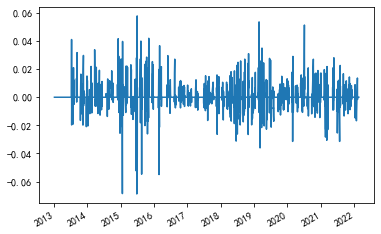

In [162]:
ser

In [175]:
monthly_ret_table = ep.aggregate_returns(ser, 'monthly')
monthly_ret_table = monthly_ret_table.unstack().round(3)

In [176]:
monthly_ret_table

,1,2,3,4,5,6,7,8,9,10,11,12
2013,0.000,0.000,0.000,0.000,0.000,0.000,0.020,0.034,0.064,-0.022,0.006,-0.014
2014,-0.057,0.045,0.028,0.036,-0.001,-0.000,0.003,-0.010,0.059,0.008,0.014,0.131
2015,-0.010,0.035,0.082,0.039,-0.032,-0.135,-0.036,0.019,-0.005,0.059,0.066,0.048
2016,0.000,-0.059,0.115,0.000,0.035,0.012,0.001,0.015,0.011,0.022,0.039,0.003
2017,0.013,0.009,-0.004,-0.004,0.000,0.001,0.017,0.020,0.002,0.018,-0.027,0.003
2018,0.010,-0.013,0.007,-0.024,0.013,-0.024,-0.017,-0.039,0.025,0.013,0.028,-0.071
2019,0.020,0.081,0.050,0.028,-0.020,0.016,0.005,-0.042,-0.027,0.011,0.016,0.033
2020,0.015,-0.027,0.061,0.010,0.010,0.060,0.131,-0.007,-0.007,0.040,0.028,0.058
2021,0.030,-0.026,-0.015,0.000,0.057,-0.004,-0.071,0.025,0.000,-0.002,-0.010,0.019
2022,-0.045,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [187]:
fig = go.Figure(data=go.Heatmap(z=monthly_ret_table.values,
                labels=dict(x="Month", y="Year"),
                x=monthly_ret_table.columns.map(str),
                y=monthly_ret_table.index.tolist(),
                text=monthly_ret_table.values,
                texttemplate="%{text}",
               ))
fig.update_xaxes(side="top")

ValueError: Invalid property specified for object of type plotly.graph_objs.Heatmap: 'labels'

Did you mean "name"?

    Valid properties:
        autocolorscale
            Determines whether the colorscale is a default palette
            (`autocolorscale: true`) or the palette determined by
            `colorscale`. In case `colorscale` is unspecified or
            `autocolorscale` is true, the default  palette will be
            chosen according to whether numbers in the `color`
            array are all positive, all negative or mixed.
        coloraxis
            Sets a reference to a shared color axis. References to
            these shared color axes are "coloraxis", "coloraxis2",
            "coloraxis3", etc. Settings for these shared color axes
            are set in the layout, under `layout.coloraxis`,
            `layout.coloraxis2`, etc. Note that multiple color
            scales can be linked to the same color axis.
        colorbar
            :class:`plotly.graph_objects.heatmap.ColorBar` instance
            or dict with compatible properties
        colorscale
            Sets the colorscale. The colorscale must be an array
            containing arrays mapping a normalized value to an rgb,
            rgba, hex, hsl, hsv, or named color string. At minimum,
            a mapping for the lowest (0) and highest (1) values are
            required. For example, `[[0, 'rgb(0,0,255)'], [1,
            'rgb(255,0,0)']]`. To control the bounds of the
            colorscale in color space, use`zmin` and `zmax`.
            Alternatively, `colorscale` may be a palette name
            string of the following list: Blackbody,Bluered,Blues,C
            ividis,Earth,Electric,Greens,Greys,Hot,Jet,Picnic,Portl
            and,Rainbow,RdBu,Reds,Viridis,YlGnBu,YlOrRd.
        connectgaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the `z` data are filled in. It is defaulted
            to true if `z` is a one dimensional array and `zsmooth`
            is not false; otherwise it is defaulted to false.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            `customdata`.
        dx
            Sets the x coordinate step. See `x0` for more info.
        dy
            Sets the y coordinate step. See `y0` for more info.
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on Chart Studio Cloud for
            `hoverinfo`.
        hoverlabel
            :class:`plotly.graph_objects.heatmap.Hoverlabel`
            instance or dict with compatible properties
        hoverongaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the `z` data have hover labels associated
            with them.
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}" as well as %{xother}, {%_xother},
            {%_xother_}, {%xother_}. When showing info for several
            points, "xother" will be added to those with different
            x positions from the first point. An underscore before
            or after "(x|y)other" will add a space on that side,
            only when this field is shown. Numbers are formatted
            using d3-format's syntax %{variable:d3-format}, for
            example "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. The variables available in
            `hovertemplate` are the ones emitted as event data
            described at this link
            https://plotly.com/javascript/plotlyjs-events/#event-
            data. Additionally, every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available.  Anything contained in tag `<extra>` is
            displayed in the secondary box, for example
            "<extra>{fullData.name}</extra>". To hide the secondary
            box completely, use an empty tag `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on Chart Studio Cloud for
            `hovertemplate`.
        hovertext
            Same as `text`.
        hovertextsrc
            Sets the source reference on Chart Studio Cloud for
            `hovertext`.
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            `ids`.
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        legendgrouptitle
            :class:`plotly.graph_objects.heatmap.Legendgrouptitle`
            instance or dict with compatible properties
        legendrank
            Sets the legend rank for this trace. Items and groups
            with smaller ranks are presented on top/left side while
            with `*reversed* `legend.traceorder` they are on
            bottom/right side. The default legendrank is 1000, so
            that you can use ranks less than 1000 to place certain
            items before all unranked items, and ranks greater than
            1000 to go after all unranked items.
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            `meta`.
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        opacity
            Sets the opacity of the trace.
        reversescale
            Reverses the color mapping if true. If true, `zmin`
            will correspond to the last color in the array and
            `zmax` will correspond to the first color.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        showscale
            Determines whether or not a colorbar is displayed for
            this trace.
        stream
            :class:`plotly.graph_objects.heatmap.Stream` instance
            or dict with compatible properties
        text
            Sets the text elements associated with each z value.
        textfont
            Sets the text font.
        textsrc
            Sets the source reference on Chart Studio Cloud for
            `text`.
        texttemplate
            Template string used for rendering the information text
            that appear on points. Note that this will override
            `textinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. Every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available. variables `x`, `y`, `z` and `text`.
        transpose
            Transposes the z data.
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        x
            Sets the x coordinates.
        x0
            Alternate to `x`. Builds a linear space of x
            coordinates. Use with `dx` where `x0` is the starting
            coordinate and `dx` the step.
        xaxis
            Sets a reference between this trace's x coordinates and
            a 2D cartesian x axis. If "x" (the default value), the
            x coordinates refer to `layout.xaxis`. If "x2", the x
            coordinates refer to `layout.xaxis2`, and so on.
        xcalendar
            Sets the calendar system to use with `x` date data.
        xgap
            Sets the horizontal gap (in pixels) between bricks.
        xhoverformat
            Sets the hover text formatting rulefor `x`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `xaxis.hoverformat`.
        xperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the x
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        xperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the x0 axis. When `x0period` is round number
            of weeks, the `x0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        xperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the x axis.
        xsrc
            Sets the source reference on Chart Studio Cloud for
            `x`.
        xtype
            If "array", the heatmap's x coordinates are given by
            "x" (the default behavior when `x` is provided). If
            "scaled", the heatmap's x coordinates are given by "x0"
            and "dx" (the default behavior when `x` is not
            provided).
        y
            Sets the y coordinates.
        y0
            Alternate to `y`. Builds a linear space of y
            coordinates. Use with `dy` where `y0` is the starting
            coordinate and `dy` the step.
        yaxis
            Sets a reference between this trace's y coordinates and
            a 2D cartesian y axis. If "y" (the default value), the
            y coordinates refer to `layout.yaxis`. If "y2", the y
            coordinates refer to `layout.yaxis2`, and so on.
        ycalendar
            Sets the calendar system to use with `y` date data.
        ygap
            Sets the vertical gap (in pixels) between bricks.
        yhoverformat
            Sets the hover text formatting rulefor `y`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `yaxis.hoverformat`.
        yperiod
            Only relevant when the axis `type` is "date". Sets the
            period positioning in milliseconds or "M<n>" on the y
            axis. Special values in the form of "M<n>" could be
            used to declare the number of months. In this case `n`
            must be a positive integer.
        yperiod0
            Only relevant when the axis `type` is "date". Sets the
            base for period positioning in milliseconds or date
            string on the y0 axis. When `y0period` is round number
            of weeks, the `y0period0` by default would be on a
            Sunday i.e. 2000-01-02, otherwise it would be at
            2000-01-01.
        yperiodalignment
            Only relevant when the axis `type` is "date". Sets the
            alignment of data points on the y axis.
        ysrc
            Sets the source reference on Chart Studio Cloud for
            `y`.
        ytype
            If "array", the heatmap's y coordinates are given by
            "y" (the default behavior when `y` is provided) If
            "scaled", the heatmap's y coordinates are given by "y0"
            and "dy" (the default behavior when `y` is not
            provided)
        z
            Sets the z data.
        zauto
            Determines whether or not the color domain is computed
            with respect to the input data (here in `z`) or the
            bounds set in `zmin` and `zmax`  Defaults to `false`
            when `zmin` and `zmax` are set by the user.
        zhoverformat
            Sets the hover text formatting rulefor `z`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see: https://github.com/d
            3/d3-format/tree/v1.4.5#d3-format.By default the values
            are formatted using generic number format.
        zmax
            Sets the upper bound of the color domain. Value should
            have the same units as in `z` and if set, `zmin` must
            be set as well.
        zmid
            Sets the mid-point of the color domain by scaling
            `zmin` and/or `zmax` to be equidistant to this point.
            Value should have the same units as in `z`. Has no
            effect when `zauto` is `false`.
        zmin
            Sets the lower bound of the color domain. Value should
            have the same units as in `z` and if set, `zmax` must
            be set as well.
        zsmooth
            Picks a smoothing algorithm use to smooth `z` data.
        zsrc
            Sets the source reference on Chart Studio Cloud for
            `z`.
        
Did you mean "name"?

Bad property path:
labels
^^^^^^

In [179]:
monthly_ret_table.columns.tolist()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]